In [1]:
import pandas as pd
import numpy as np
from scipy import spatial
from astropy.table import Table
from astropy.cosmology import LambdaCDM as Cos
import matplotlib.pyplot as plt
from IPython import display 
import scipy

import pickle
import dask

# To do:
Cross match with redmapper

Aggregate neighbors using gid's (using ~isin)



## Debugging

In [2]:
#pd.options.mode.chained_assignment = 'raise'
pd.options.mode.chained_assignment = 'warn'

np.seterr(divide = 'ignore')
#np.seterr(divide = 'warn') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Instantiate Dask Cluster Instance

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers = 8)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:43425 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 67.31 GB


## Load Data

In [4]:
#Load Data
with open("sweep-000m005-010p000_trim2.pkl", "rb") as f:
    ra_dec = pickle.load(f)

## Cuts, coordinates, and binning

In [5]:
#Basic cuts and conversion to radians
#ra_dec = dd.from_pandas(ra_dec0)
ra_dec = ra_dec[ra_dec.MASKBITS == 0]
ra_dec["magR"] = 22.5-np.log(ra_dec.FLUX_R)
ra_dec["magZ"] = 22.5-np.log(ra_dec.FLUX_Z)
ra_dec["magW1"] = 22.5-np.log(ra_dec.FLUX_W1)
ra_dec = ra_dec[np.logical_or(np.logical_or(ra_dec.gaia_phot_g_mean_mag > 19, ra_dec.gaia_astrometric_excess_noise > 10**.5), ra_dec.gaia_astrometric_excess_noise==0)]
ra_dec = ra_dec[(ra_dec.magR - ra_dec.magW1) > 1.8*(ra_dec.magR-ra_dec.magZ)-0.6]
ra_dec = ra_dec[np.logical_and(22.5 - 2.5*np.log10(ra_dec.FLUX_Z)<21, ra_dec.z_phot_median>0.01)]
ra_dec["RA_r"] = (np.pi/180)*ra_dec["RA"]
ra_dec["DEC_r"] = (np.pi/180)*ra_dec["DEC"]
ra_dec["gid"] = ra_dec.BRICKID.astype("int64")*(2**32) + ra_dec.OBJID

#Oversampling
oversample = 7
gauss = ra_dec.sample(n = int(oversample*len(ra_dec)), replace = True)
random1 = np.random.normal(loc = 0, scale = 0.1, size = int(oversample*len(ra_dec)))
gauss["z_phot_median"] = gauss["z_phot_median"] + random1*gauss["z_phot_std"]

#Binning by redshift
bins = np.arange(0.1, ra_dec.z_phot_median.max(), 0.01)
binned = [ra_dec[np.logical_and(ra_dec.z_phot_median>=i-.025, ra_dec.z_phot_median<=i+.025)].copy() for i in bins] #.copy added to prevent chained assignment from causing settingwithcopywarning (this code otherwise returns a view)
bins_g = np.arange(0.1, ra_dec.z_phot_median.max(), 0.01)
binned_g = [gauss[np.logical_and(gauss.z_phot_median>=i-.025, gauss.z_phot_median<=i+.025)].copy() for i in bins]

#Cartesian coordinates
cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
for i in range(0, len(binned)):
    mean = binned[i].z_phot_median.mean()
    binned[i]["z"] = cos.comoving_distance(mean)*np.ones(len(binned[i]))
    binned[i]["y"] = cos.comoving_distance(mean)*binned[i]["DEC_r"]
    binned[i]["x"] = cos.comoving_distance(mean)*binned[i]["RA_r"]*np.cos(binned[i]["DEC_r"])
for i in range(0, len(binned_g)):
    mean = binned_g[i].z_phot_median.mean()
    binned_g[i]["z"] = cos.comoving_distance(mean)*np.ones(len(binned_g[i]))
    binned_g[i]["y"] = cos.comoving_distance(mean)*binned_g[i]["DEC_r"]
    binned_g[i]["x"] = cos.comoving_distance(mean)*binned_g[i]["RA_r"]*np.cos(binned_g[i]["DEC_r"])

## Example bin for certain examples

In [6]:
sample_real = binned[40]
massive_sample = sample_real[sample_real.mass>11]

## Function: Initial Clustering and Aggregation by bin

In [133]:
@dask.delayed
def mclusters(binned, binned_g, C = 2, rc = 2.3):
    sample_real = binned.copy()
    massive_sample = sample_real[sample_real.mass>11.3].copy()
    if len(massive_sample)>0:
        massive_tree = spatial.cKDTree(massive_sample[["x", "y"]], copy_data = True)
        sample = binned_g.copy()
        tree = spatial.cKDTree(sample[["x", "y"]], copy_data = True)
        
        z = massive_sample.z_phot_median.mean()
        r = rc*(1+z)/(1+0.5)
        neighbors = massive_tree.query_ball_tree(tree, r)
        counts = np.zeros(len(neighbors))
        for i in range(0, len(neighbors)):
            counts[i] = len(neighbors[i])
        
        sample.reset_index(inplace=True, drop = True)
        massive_sample.reset_index(inplace=True, drop = True)
        massive_sample["neighbor_numbers"] = pd.Series(neighbors)
        massive_sample["neighbors"] = pd.Series(counts)/oversample
        
        ##########################################################################################################
        neighbor_gids = np.empty(len(massive_sample), dtype=np.object)
        gids = sample.gid.to_numpy()
        for i in range (0, len(massive_sample)):
            neighbor_gids[i] = gids[massive_sample.neighbor_numbers[i]].tolist()
        massive_sample["neighbor_gids"] = neighbor_gids
        
        masses = 10**sample.mass.to_numpy()/oversample
        neighbor_mass = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            neighbor_mass[i] = np.log10(np.sum(masses[massive_sample.neighbor_numbers[i]]))
        massive_sample["neighbor_mass"] = neighbor_mass
        massive_sample["neighbor_mass_wo"] = np.log10(10**massive_sample.neighbor_mass - 10**massive_sample.mass)
        
        masses = 10**sample.mass.to_numpy()/oversample
        neighbor_mass_massive = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            local_masses = masses[massive_sample.neighbor_numbers[i]]
            neighbor_mass_massive[i] = np.log10(np.sum(local_masses[local_masses > 10**10.75]))
        massive_sample["neighbor_mass_massive"] = neighbor_mass_massive
        
        reds = sample.z_phot_median.to_numpy()
        mean_red = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            mean_red[i] = np.mean(reds[massive_sample.neighbor_numbers[i]])
        massive_sample["mean_red"] = mean_red
        
        med_red = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            med_red[i] = np.median(reds[massive_sample.neighbor_numbers[i]])
        massive_sample["med_red"] = med_red
        
        mean_x = np.zeros(len(massive_sample))
        xs = sample.x.to_numpy()
        for i in range (0, len(massive_sample)):
            mean_x[i] = np.mean(xs[massive_sample.neighbor_numbers[i]])
        massive_sample["mean_x"] = mean_x
        
        mean_y = np.zeros(len(massive_sample))
        ys = sample.y.to_numpy()
        for i in range (0, len(massive_sample)):
            mean_y[i] = np.mean(ys[massive_sample.neighbor_numbers[i]])
        massive_sample["mean_y"] = mean_y
        
        ##############################################################################################################
        lr = 0.5*(1+z)
        lneighbors = massive_tree.query_ball_tree(tree, lr)
        lcounts = np.zeros(len(lneighbors))
        for i in range(0, len(lneighbors)):
            lcounts[i] = len(lneighbors[i])
        
        sample.reset_index(inplace=True, drop = True)
        massive_sample.reset_index(inplace=True, drop = True)
        massive_sample["local_neighbor_numbers"] = pd.Series(lneighbors)
        massive_sample["local_neighbors"] = pd.Series(lcounts)/oversample
        
        lneighbor_gids = np.empty(len(massive_sample), dtype=np.object)
        gids = sample.gid.to_numpy()
        for i in range (0, len(massive_sample)):
            lneighbor_gids[i] = gids[massive_sample.local_neighbor_numbers[i]].tolist()
        massive_sample["local_neighbor_gids"] = lneighbor_gids
        
        masses = 10**sample.mass.to_numpy()/oversample
        local_neighbor_mass = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            local_neighbor_mass[i] = np.log10(np.sum(masses[massive_sample.local_neighbor_numbers[i]]))
        massive_sample["local_neighbor_mass"] = local_neighbor_mass
        massive_sample["local_neighbor_mass_wo"] = np.log10(10**massive_sample.local_neighbor_mass - 10**massive_sample.mass)
        
        masses = 10**sample.mass.to_numpy()/oversample
        local_neighbor_mass_massive = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            loop_masses = masses[massive_sample.local_neighbor_numbers[i]]
            local_neighbor_mass_massive[i] = np.log10(np.sum(loop_masses[loop_masses > 10**10.75]))
        massive_sample["local_neighbor_mass_massive"] = local_neighbor_mass_massive
        #################################################################################################################
        threshold = (C*(1 + z)**1.2*np.median(counts/oversample))/(1 + 0.5)**1.2 #Idea: scale C as 2.7/(1+z)**2 optionally with a boolean for scaling optionally
        clusters = massive_sample[massive_sample.neighbors>=threshold].copy()
        
        if len(clusters)>0:
            cluster_tree = spatial.cKDTree(clusters[["x", "y"]])
            cluster_tree2 = spatial.cKDTree(clusters[["x", "y"]].copy())
            neighbors_c = cluster_tree.query_ball_tree(cluster_tree2, r)
            clusters.reset_index(inplace= True)
            clusters["cluster_neighbor_numbers"] = pd.Series(neighbors_c) #Neighboring galaxies with neighbors>threshold
            
            clusters.sort_values("local_neighbor_mass_wo", inplace = True)
            clusters["ncluster"] = np.zeros(len(clusters))
            clusternum = 1
            
            for index in range(len(clusters)):
                if clusters.at[index, "ncluster"] == 0:
                    clusters.at[index, "ncluster"] = clusternum
                    for index2 in clusters.at[index, "cluster_neighbor_numbers"]:
                        if clusters.at[index2, "ncluster"] == 0:
                            clusters.at[index2, "ncluster"] = clusternum
                            
                    clusternum+=1
            
            cluster_center = clusters.sort_values(by = ['ncluster','mass'], ascending = [True, False]).groupby('ncluster').head(1)
        else:
            cluster_center = pd.DataFrame([[]])
            
    else:
        clusters = pd.DataFrame([[]])
        cluster_center = pd.DataFrame([[]])
    
    return cluster_center

## Delaying data for dask

In [134]:
dbinned = dask.delayed(binned)
dbinned_g = dask.delayed(binned_g)

## Evaluation: Initial Clustering and Aggregation by bin

In [135]:
cluster_bins = []
cluster_gal_bins = []
delayed_results = []
for b in range(len(binned)):
    delayed_result = mclusters(dbinned[b], dbinned_g[b])
    delayed_results.append(delayed_result)

In [136]:
results = dask.compute(*delayed_results)

In [137]:
cluster_centrals = pd.DataFrame()
for i in range(len(results)):
    cluster_centrals = pd.concat([cluster_centrals, results[i]])
client.restart()

Client Scheduler: tcp://127.0.0.1:43425 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 67.31 GB


In [138]:
len(cluster_centrals)

3448

## Comoving and scaled z coordinates

In [139]:
cluster_centrals["comoving"] = cos.comoving_distance(cluster_centrals["mean_red"])

In [140]:
dz = 0.1
cluster_centrals["mean_red_z_scaled"] = cluster_centrals["mean_red"]*(2.3/(dz*cos.hubble_distance*cos.inv_efunc(cluster_centrals["mean_red"])))

## 3D Aggregation

In [141]:
#cluster_centrals.sort_values("cluster_mass_add", ascending = False, inplace = True)
cluster_centrals.sort_values("local_neighbor_mass_wo", ascending = False, inplace = True)
cluster_centrals.reset_index(inplace = True, drop = True)
cluster_centrals["ncluster_3D"] = np.zeros(len(cluster_centrals), dtype = int)
cluster_centrals["y_local"] = np.zeros(len(cluster_centrals))
cluster_centrals["x_local"] = np.zeros(len(cluster_centrals))
clusternum = 1
xyradius = 5
zradius = 0.1

# faster algorithm: calculate ymin and ymax, xmin and xmax, zmin and zmax based on error in z (0.1). Three trees (one for centrals' real cluster centers, one for 
# minimum coordinates, one for maximum coordinates) and do real_cluster_centers.query_ball_tree(each tree, r). Maybe use an even larger R. Then use the neighbors 
# obtained from these in the for loop to test radius more precisely.


for index in range(len(cluster_centrals)):
    if cluster_centrals.at[index, "ncluster_3D"] == 0 and cluster_centrals.at[index, "neighbors"] > 0:
        com = cos.comoving_distance(cluster_centrals.at[index, "mean_red"]).value
        cluster_centrals.at[index, "y_local"] = com*cluster_centrals.at[index, "DEC_r"]
        cluster_centrals.at[index, "x_local"] = com*cluster_centrals.at[index, "RA_r"]*np.cos(cluster_centrals.at[index, "DEC_r"])
        cluster_centrals.at[index, "ncluster_3D"] = clusternum
        
        cluster_centrals.y_local = com*cluster_centrals["DEC_r"]
        cluster_centrals.x_local = com*cluster_centrals["RA_r"]*np.cos(cluster_centrals["DEC_r"])
        x_const = cluster_centrals.at[index, 'x_local']
        y_const = cluster_centrals.at[index, 'y_local']
        r_const = cluster_centrals.at[index, 'mean_red']
        test_x = (np.abs(cluster_centrals.x_local.values-x_const)<xyradius).flatten()
        test_y = (np.abs(cluster_centrals.y_local.values-y_const)<xyradius).flatten()
        test_z = (np.abs(cluster_centrals.mean_red.values-r_const)<zradius).flatten()
        test_n = (cluster_centrals.ncluster_3D.values == 0).flatten()
        cluster_centrals.loc[((test_x) & (test_y) & (test_z) & (test_n)), "ncluster_3D"] = clusternum
        
        # Saving local x,y coordinates for each galaxy in cluster
        cluster_centrals.at[index, 'y_individual'] = com*cluster_centrals.at[index, "DEC_r"]
        cluster_centrals.at[index, 'x_individual'] = com*cluster_centrals.at[index, "RA_r"]*np.cos(cluster_centrals.at[index, "DEC_r"])
        cluster_centrals.loc[((test_x) & (test_y) & (test_z) & (test_n)), "y_individual"] = com*cluster_centrals.loc[((test_x) & (test_y) & (test_z) & (test_n))].DEC_r
        cluster_centrals.loc[((test_x) & (test_y) & (test_z) & (test_n)), "x_individual"] = com*cluster_centrals.loc[((test_x) & (test_y) & (test_z) & (test_n))].RA_r*np.cos(cluster_centrals.loc[((test_x) & (test_y) & (test_z) & (test_n))].DEC_r)
        
        # Cluster averages
        mean_z = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z) & (test_n))].z_phot_median)
        mean_x = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z) & (test_n))].x_local)
        mean_y = np.mean(cluster_centrals.loc[((test_x) & (test_y) & (test_z) & (test_n))].y_local)
        cluster_centrals.at[index, 'mean_z_cluster'] = mean_z
        cluster_centrals.at[index, 'mean_x_cluster'] = mean_x
        cluster_centrals.at[index, 'mean_y_cluster'] = mean_y
        cluster_centrals.loc[((test_x) & (test_y) & (test_z) & (test_n)), "mean_z_cluster"] = mean_z
        cluster_centrals.loc[((test_x) & (test_y) & (test_z) & (test_n)), "mean_x_cluster"] = mean_x
        cluster_centrals.loc[((test_x) & (test_y) & (test_z) & (test_n)), "mean_y_cluster"] = mean_y
        #print(gal.ncluster_3D)
        #print(gal.mass)
        #print(cluster_centrals[["RA", "DEC", "mass", "ncluster_3D"]].loc[((test_x) & (test_y) & (test_z) & (test_n))])
        clusternum+=1
        
cluster_centrals_3D = cluster_centrals[cluster_centrals.ncluster_3D>0].sort_values(by = ['ncluster_3D','local_neighbor_mass'], ascending = [True, False]).groupby('ncluster_3D').head(1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


In [142]:
len(cluster_centrals_3D)

679

In [143]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
cluster_centrals_3D[["RA", "DEC", "gid", "mean_red"]][cluster_centrals_3D.local_neighbors > 5/(1+cluster_centrals_3D.z_phot_median)].head(50)

,RA,DEC,gid,mean_red
0,1.734,-0.681,1400391266735809.000,0.538
2,8.720,-3.044,1344848749660371.000,0.473
3,7.870,-1.733,1375759629291195.000,0.560
10,9.967,-1.939,1369609236125115.000,0.345
21,1.831,-3.444,1332380459602716.000,0.383
16,0.360,-0.029,1418924050614636.000,0.256
18,4.379,-0.081,1418992770090076.000,0.792
20,0.600,-0.518,1406558839770233.000,0.283
23,6.802,-4.944,1295435150922334.000,0.717
27,8.237,-1.659,1375763924260496.000,0.483


In [144]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
cluster_centrals_3D[["RA", "DEC", "gid", "mean_red", "local_neighbors"]][cluster_centrals_3D.local_neighbors > 5/(1+cluster_centrals_3D.z_phot_median)**2].tail(50)

,RA,DEC,gid,mean_red,local_neighbors
2560,8.700,-2.001,1369587761286805.000,0.993,1.286
2564,6.181,-1.633,1375729564523557.000,0.635,2.429
2571,2.400,-3.809,1326212886562764.000,0.902,1.571
2662,6.969,-0.516,1406666213952089.000,0.818,2.143
2587,8.452,-2.513,1357213960506466.000,0.921,2.714
2596,8.759,-2.669,1351037797538370.000,0.607,4.714
2602,5.081,-4.726,1301572659187893.000,0.384,4.429
2604,0.590,-3.356,1338535147733739.000,0.822,2.000
2610,1.365,-4.547,1307675807713706.000,0.996,2.000
2628,9.436,-0.547,1406709163624888.000,0.990,1.429


In [145]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
cluster_centrals_3D[["RA", "DEC"]].tail(50)

,RA,DEC
3006,7.903,-4.000
3020,0.107,-0.581
3030,8.199,-0.337
3035,9.421,-1.668
3046,3.190,-3.609
3052,5.174,-0.690
3099,4.670,-3.319
3115,6.045,-0.727
3137,9.329,-2.720
3144,0.923,-0.761


--------------------------------------------------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------------------------

# Analytics 

### Looking at clusters

In [78]:
from astropy.io import fits

In [85]:
weird_clus = cluster_centrals_3D[["neighbor_gids"]][cluster_centrals_3D["gid"] == 1307766002031090.0].to_numpy()[0][0]
weird_cluster = pd.DataFrame(weird_clus)
for_fits = pd.DataFrame([])
for i, ids in weird_cluster.iterrows():
    for_fits = for_fits.append(ra_dec[["RA", "DEC"]][ra_dec["gid"] == int(ids)])
for_fits.reset_index(inplace = True, drop = True)

hdu = fits.BinTableHDU.from_columns([fits.Column(name='RA', format='E', array=for_fits[["RA"]]), fits.Column(name='DEC', format='E', array=for_fits[["DEC"]])])
hdu.writeto('clus4.fits')

In [86]:
weird_clus = cluster_centrals_3D[["local_neighbor_gids"]][cluster_centrals_3D["gid"] == 1307766002031090.0].to_numpy()[0][0]
weird_cluster = pd.DataFrame(weird_clus)
for_fits = pd.DataFrame([])
for i, ids in weird_cluster.iterrows():
    for_fits = for_fits.append(ra_dec[["RA", "DEC"]][ra_dec["gid"] == int(ids)])
for_fits.reset_index(inplace = True, drop = True)

hdu = fits.BinTableHDU.from_columns([fits.Column(name='RA', format='E', array=for_fits[["RA"]]), fits.Column(name='DEC', format='E', array=for_fits[["DEC"]])])
hdu.writeto('clus4_local.fits')

## Cross Matching with Redmapper

In [157]:
redmapper = fits.open("redmapper_dr8_public_v6.3_catalog.fits.gz")
redmapper.info()
redmap = redmapper[1]
from astropy.table import Table
dat = Table.read('redmapper_dr8_public_v6.3_catalog.fits.gz', format='fits')
dat.remove_columns(["P_CEN", "RA_CEN", "DEC_CEN", "ID_CEN", "PZBINS", "PZ"])
df = dat.to_pandas()

Filename: redmapper_dr8_public_v6.3_catalog.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     77   26111R x 30C   [J, 20A, D, D, E, E, E, E, E, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5K, 21E, 21E]   


In [158]:
df.head()

,ID,NAME,RA,DEC,Z_LAMBDA,Z_LAMBDA_ERR,LAMBDA,LAMBDA_ERR,S,Z_SPEC,...,MODEL_MAGERR_U,MODEL_MAG_G,MODEL_MAGERR_G,MODEL_MAG_R,MODEL_MAGERR_R,MODEL_MAG_I,MODEL_MAGERR_I,MODEL_MAG_Z,MODEL_MAGERR_Z,ILUM
0,1,b'RMJ155820.0+271400.3',239.583,27.233,0.095,0.005,169.838,4.187,1.011,0.091,...,0.050,15.415,0.004,14.397,0.003,13.978,0.003,13.620,0.005,115.150
1,2,b'RMJ164019.8+464241.5',250.083,46.712,0.233,0.006,199.539,5.300,0.995,-1.000,...,0.145,17.981,0.014,16.546,0.007,16.049,0.007,15.815,0.019,132.716
2,3,b'RMJ131129.5-012028.0',197.873,-1.341,0.182,0.004,164.712,4.242,1.007,-1.000,...,0.496,16.889,0.010,15.687,0.006,15.249,0.005,15.028,0.014,118.677
3,5,b'RMJ090912.2+105824.9',137.301,10.974,0.170,0.004,174.704,4.948,1.015,-1.000,...,3.217,18.158,0.023,17.184,0.014,16.532,0.011,16.288,0.028,112.058
4,6,b'RMJ133520.1+410004.1',203.834,41.001,0.232,0.006,189.181,5.613,1.010,0.228,...,0.108,17.902,0.009,16.367,0.005,15.851,0.004,15.508,0.011,128.979


In [216]:
from astropy.coordinates import SkyCoord
from astropy import units as u
#ra2, dec2 from redmapper
c = SkyCoord(ra=cluster_centrals_3D.RA.to_numpy()*u.degree, dec=cluster_centrals_3D.DEC.to_numpy()*u.degree)
catalog = SkyCoord(ra=df.RA.to_numpy()*u.degree, dec=df.DEC.to_numpy()*u.degree)

max_sep = 5.0 * u.arcmin
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
c_matches = c[sep_constraint]
catalog_matches = catalog[idx[sep_constraint]]

In [217]:
len(cluster_centrals_3D.mean_red)

679

In [218]:
len(d2d.value)

679

In [219]:
len(df.iloc[idx].Z_LAMBDA)

679

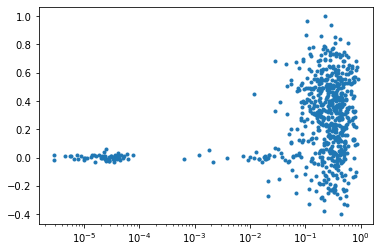

In [220]:
plt.semilogx(d2d.value, cluster_centrals_3D.mean_red.to_numpy()-df.iloc[idx].Z_LAMBDA.to_numpy(), ".")
plt.show()

In [221]:
len(cluster_centrals_3D[d2d.value > 10e-3][["RA", "DEC", "mean_red"]])

614

In [222]:
cluster_centrals_3D[d2d.value > 10e-3].mean_red.mean()

0.6701112412494822

In [223]:
cluster_centrals_3D[d2d.value > 10e-3][["RA", "DEC", "mean_red"]][250:300].tail(50)

,RA,DEC,mean_red
1180,5.704,-0.183,0.530
1182,9.755,-2.278,0.723
1183,8.671,-1.971,0.319
1184,3.709,-4.756,0.886
1192,7.642,-0.448,0.216
1199,1.552,-3.037,0.620
1208,0.606,-2.190,0.800
1211,8.448,-3.314,0.714
1219,8.154,-3.201,0.540
1612,7.520,-0.876,0.704


In [224]:
dfr = df[np.logical_and(np.logical_and(df.RA<cluster_centrals_3D.RA.max(), df.RA>cluster_centrals_3D.RA.min()), np.logical_and(df.DEC<cluster_centrals_3D.DEC.max(), df.DEC>cluster_centrals_3D.DEC.min()))]
max_sep = 5.0 * u.arcmin
catalog = SkyCoord(ra=dfr.RA.to_numpy()*u.degree, dec=dfr.DEC.to_numpy()*u.degree)
idx, d2d, d3d = catalog.match_to_catalog_sky(c)
sep_constraint = d2d < max_sep
catalog_matches = catalog[sep_constraint]
c_matches = c[idx[sep_constraint]]

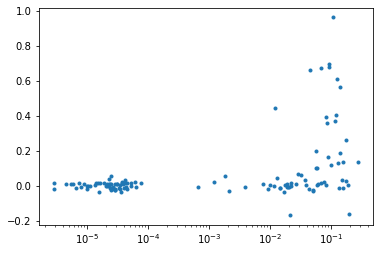

In [225]:
plt.semilogx(d2d.value, cluster_centrals_3D.iloc[idx].mean_red.to_numpy()-dfr.Z_LAMBDA.to_numpy(), ".")
plt.show()

In [226]:
cluster_centrals_3D.iloc[idx][d2d.value < 10e-3][["RA", "DEC"]].head(50)

,RA,DEC
51,4.407,-0.878
151,5.963,-0.109
125,9.866,-4.780
143,3.192,-1.590
146,2.437,-4.961
256,6.030,-4.746
50,6.476,-4.324
31,6.691,-4.413
309,9.479,-0.113
0,1.734,-0.681


In [227]:
len(cluster_centrals_3D.iloc[idx][d2d.value < 10e-3])

64

In [228]:
dfr[d2d.value > 10e-3].Z_LAMBDA.mean()

0.35772308707237244

In [231]:
cluster_centrals_3D.iloc[idx][d2d.value > 10e-3][["RA", "DEC"]].head(54)

,RA,DEC
646,5.807,-0.126
2,8.720,-3.044
2154,5.884,-1.744
27,8.237,-1.659
10,9.967,-1.939
623,1.962,-3.816
1178,4.081,-1.119
301,6.136,-2.699
2463,7.015,-2.547
2678,8.927,-2.589


In [229]:
dfr[d2d.value > 10e-3][["RA", "DEC", "Z_LAMBDA"]].head(54)

,RA,DEC,Z_LAMBDA
301,5.780,-0.064,0.164
651,8.734,-3.031,0.461
2468,5.937,-1.631,0.083
3563,8.250,-1.646,0.492
3632,9.845,-1.870,0.161
3864,1.927,-3.768,0.252
4093,4.228,-1.133,0.162
4096,6.157,-2.626,0.215
4352,7.108,-2.551,0.387
4832,8.934,-2.633,0.359


## Distribution of neighbors, galaxies above threshold, and clusters as function of redshift

In [73]:
def clusters_dist(binned, binned_g, C = 2.7):
    sample_real = binned.copy()
    massive_sample = sample_real[sample_real.mass>11].copy()
    if len(massive_sample)>0:
        massive_tree = spatial.cKDTree(massive_sample[["x", "y"]])
        sample = binned_g.copy()
        tree = spatial.cKDTree(sample[["x", "y"]])
        z = massive_sample.z_phot_median.mean()
        r = 2.3*(1+z)/(1+0.5)
        neighbors = massive_tree.query_ball_tree(tree, r)
        counts = np.array([])
        for i in range(0, len(neighbors)):
            counts = np.append(counts, len(neighbors[i]))
        
        sample.reset_index(inplace=True, drop = True)
        massive_sample.reset_index(inplace=True, drop = True)
        massive_sample["neighbor_numbers"] = pd.Series(neighbors)
        massive_sample["neighbors"] = pd.Series(counts)
        
        masses = 10**sample.mass.to_numpy()
        massive_sample["neighbor_mass"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample.at[i, "neighbor_mass"] = np.log10(np.sum(masses[massive_sample.neighbor_numbers[i]]))
        
        reds = sample.z_phot_median.to_numpy()
        massive_sample["mean_red"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample.at[i, "mean_red"] = np.mean(reds[massive_sample.neighbor_numbers[i]])
        
        massive_sample["med_red"] = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            massive_sample.at[i, "med_red"] = np.median(reds[massive_sample.neighbor_numbers[i]])
            
        ##############################################################################################################
        lr = 0.5*(1+z)
        lneighbors = massive_tree.query_ball_tree(tree, lr)
        lcounts = np.zeros(len(lneighbors))
        for i in range(0, len(lneighbors)):
            lcounts[i] = len(lneighbors[i])
        
        sample.reset_index(inplace=True, drop = True)
        massive_sample.reset_index(inplace=True, drop = True)
        massive_sample["local_neighbor_numbers"] = pd.Series(lneighbors)
        massive_sample["local_neighbors"] = pd.Series(lcounts)/oversample
        
        masses = 10**sample.mass.to_numpy()/oversample
        local_neighbor_mass = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            local_neighbor_mass[i] = np.log10(np.sum(masses[massive_sample.local_neighbor_numbers[i]]))
        massive_sample["local_neighbor_mass"] = local_neighbor_mass
        massive_sample["local_neighbor_mass_wo"] = np.log10(10**massive_sample.local_neighbor_mass - 10**massive_sample.mass)
        
        masses = 10**sample.mass.to_numpy()/oversample
        local_neighbor_mass_massive = np.zeros(len(massive_sample))
        for i in range (0, len(massive_sample)):
            loop_masses = masses[massive_sample.local_neighbor_numbers[i]]
            local_neighbor_mass_massive[i] = np.log10(np.sum(loop_masses[loop_masses > 10**11.1]))
        massive_sample["local_neighbor_mass_massive"] = local_neighbor_mass_massive
        
        ####################################################################################################
        
        threshold = (C*(1 + z)**1.2*np.median(counts))/(1 + 0.5)**1.2 #Idea: scale C as 2.7/(1+z)**2 optionally with a boolean for scaling optionally
        clusters = massive_sample[massive_sample.neighbors>=threshold].copy()
        
        if len(clusters)>0:
            cluster_tree = spatial.cKDTree(clusters[["x", "y"]])
            cluster_tree2 = spatial.cKDTree(clusters[["x", "y"]].copy())
            r = 2.3
            neighbors_c = cluster_tree.query_ball_tree(cluster_tree2, r)
            clusters.reset_index(inplace= True)
            clusters.drop(columns = ["neighbor_numbers"])
            clusters["neighbor_numbers"] = pd.Series(neighbors_c)
            
            clusters.sort_values("local_neighbor_mass", inplace = True)
            clusters["ncluster"] = np.zeros(len(clusters))
            sample["ncluster"] = np.zeros(len(sample))
            clusternum = 1
            
            for index, gal in clusters.iterrows():
                if gal.ncluster == 0:
                    gal.ncluster = clusternum
                    for index2 in gal.neighbor_numbers:
                        if clusters.at[index2, "ncluster"] == 0:
                            clusters.at[index2, "ncluster"] = clusternum
                    clusternum+=1
            
            most_massive = clusters.sort_values(by = ['ncluster','mass'], ascending = False).groupby('ncluster').head(1)
        else:
            most_massive = pd.DataFrame([[]])
            
    else:
        clusters = pd.DataFrame([[]])
        most_massive = pd.DataFrame([[]])
        counts = np.array([0])
        threshold = 0
    return len(clusters), len(most_massive), np.median(counts), threshold

In [74]:
dist_clusters = []
dist_most_massive = []
median_gal = []
thresh = []
pbar = display.ProgressBar(150)
pbar.display()
for b in range(0, 150, 10):
    pbar.progress = b
    values = clusters_dist(binned[b], binned_g[b])
    dist_clusters.append(values[0])
    dist_most_massive.append(values[1])
    median_gal.append(values[2])
    thresh.append(values[3])

[========================================================    ] 140/150

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


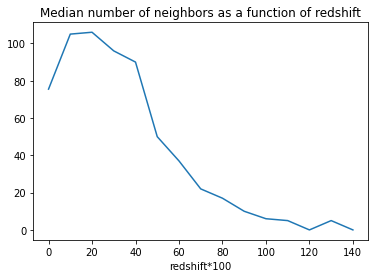

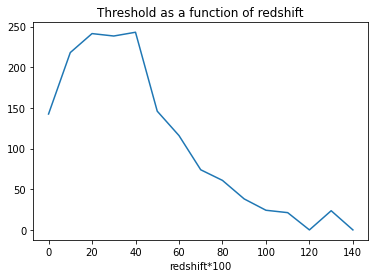

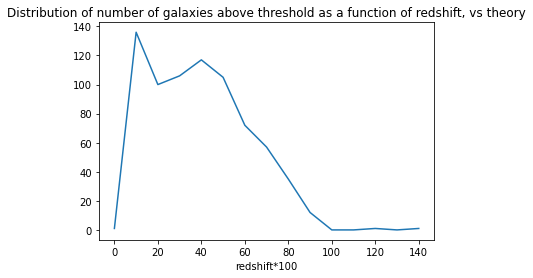

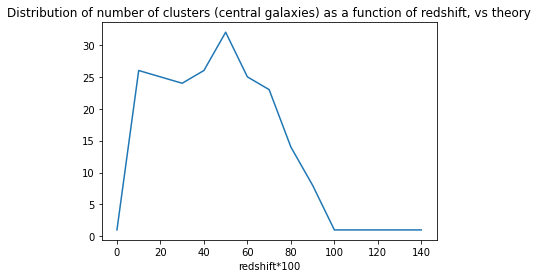

In [75]:
redshift = np.arange(0, 150, 10)
a = 1.5
b = 1.7
z0 = 0.3
r = (redshift/100)/z0
plt.plot(redshift, median_gal)
plt.title("Median number of neighbors as a function of redshift")
plt.xlabel("redshift*100")
plt.show()

plt.plot(redshift, thresh)
plt.title("Threshold as a function of redshift")
plt.xlabel("redshift*100")
plt.show()

plt.plot(redshift, dist_clusters)
#plt.plot(redshift, (25000)*(r**a)*(np.e**-r)**b)
plt.title("Distribution of number of galaxies above threshold as a function of redshift, vs theory")
plt.xlabel("redshift*100")
plt.show()
plt.plot(redshift, dist_most_massive)
#plt.plot(redshift, (12000)*(r**a)*(np.e**-r)**b)
plt.title("Distribution of number of clusters (central galaxies) as a function of redshift, vs theory")
plt.xlabel("redshift*100")
plt.show()

## DeltaZ

In [26]:
oversample = 1
gauss = ra_dec.sample(n = int(oversample*len(ra_dec)), replace = True)
random1 = np.random.normal(loc = 0, scale = 0.1, size = int(oversample*len(ra_dec)))
gauss["z_phot_median"] = gauss["z_phot_median"] + random1*gauss["z_phot_std"]

#Binning by redshift
bins = np.arange(0.1, ra_dec.z_phot_median.max(), 0.01)
binned = [ra_dec[np.logical_and(ra_dec.z_phot_median>=i-.025, ra_dec.z_phot_median<=i+.025)].copy() for i in bins] #.copy added to prevent chained assignment from causing settingwithcopywarning (this code otherwise returns a view)
bins_g = np.arange(0.1, ra_dec.z_phot_median.max(), 0.01)
binned_g = [gauss[np.logical_and(gauss.z_phot_median>=i-.025, gauss.z_phot_median<=i+.025)].copy() for i in bins]

#Cartesian coordinates
cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
for i in range(0, len(binned)):
    mean = binned[i].z_phot_median.mean()
    binned[i]["z"] = cos.comoving_distance(mean)*np.ones(len(binned[i]))
    binned[i]["y"] = cos.comoving_distance(mean)*binned[i]["DEC_r"]
    binned[i]["x"] = cos.comoving_distance(mean)*binned[i]["RA_r"]*np.cos(binned[i]["DEC_r"])
for i in range(0, len(binned_g)):
    mean = binned_g[i].z_phot_median.mean()
    binned_g[i]["z"] = cos.comoving_distance(mean)*np.ones(len(binned_g[i]))
    binned_g[i]["y"] = cos.comoving_distance(mean)*binned_g[i]["DEC_r"]
    binned_g[i]["x"] = cos.comoving_distance(mean)*binned_g[i]["RA_r"]*np.cos(binned_g[i]["DEC_r"])

In [31]:
# z = 0.3
    
sample = pd.concat(binned_g[10:30])
sample_real = binned[20].copy()
massive_sample = sample_real[sample_real.mass > 11].copy()
sample["comoving"] = cos.comoving_distance(sample["z_phot_median"])
massive_sample["comoving"] = cos.comoving_distance(massive_sample["z_phot_median"])
dz = 0.1
sample["mean_red_z_scaled"] = sample["z_phot_median"]*(2.3/(dz*cos.hubble_distance*cos.inv_efunc(sample["z_phot_median"])))
sample["mean_red_z_scaled2"] = sample["z_phot_median"]*2.3/dz
massive_sample["mean_red_z_scaled2"] = massive_sample["z_phot_median"]*2.3/dz
sample["mean_red_z_scaled3"] = sample["comoving"]/10
massive_sample["mean_red_z_scaled3"] = massive_sample["comoving"]/10
mass_tree = spatial.cKDTree(massive_sample[["x", "y", "z_phot_median"]], copy_data = True)
tree = spatial.cKDTree(sample[["x", "y", "z_phot_median"]], copy_data = True)

r = 5
neighbors = mass_tree.query_ball_tree(tree, r)
counts = np.array([])
for i in range(0, len(neighbors)):
    counts = np.append(counts, len(neighbors[i]))
        
sample.reset_index(inplace=True, drop = True)
massive_sample.reset_index(drop = True, inplace=True)
massive_sample["neighbor_numbers"] = pd.Series(neighbors)
massive_sample["neighbors"] = pd.Series(counts)

deltaz = np.array([])
for i in range(0, len(massive_sample)):
    deltas = np.ones(len(massive_sample.neighbor_numbers[i]))*massive_sample.z_phot_median[i] - sample.z_phot_median[massive_sample.neighbor_numbers[i]]
    deltaz = np.append(deltaz, deltas)

[]

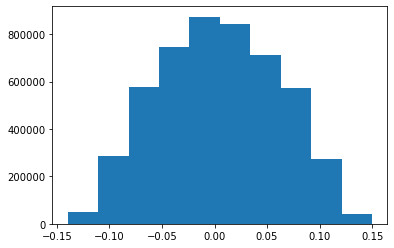

In [32]:
plt.hist(deltaz)
plt.plot()

In [29]:
# z = 0.5
    
sample = pd.concat(binned_g[30:50])
sample_real = binned[40].copy()
massive_sample = sample_real[sample_real.mass > 11].copy()
sample["comoving"] = cos.comoving_distance(sample["z_phot_median"])
massive_sample["comoving"] = cos.comoving_distance(massive_sample["z_phot_median"])
dz = 0.1
sample["mean_red_z_scaled"] = sample["z_phot_median"]*(2.3/(dz*cos.hubble_distance*cos.inv_efunc(sample["z_phot_median"])))
sample["mean_red_z_scaled2"] = sample["z_phot_median"]*2.3/dz
massive_sample["mean_red_z_scaled2"] = massive_sample["z_phot_median"]*2.3/dz
sample["mean_red_z_scaled3"] = sample["comoving"]/10
massive_sample["mean_red_z_scaled3"] = massive_sample["comoving"]/10
mass_tree = spatial.cKDTree(massive_sample[["x", "y", "z_phot_median"]], copy_data = True)
tree = spatial.cKDTree(sample[["x", "y", "z_phot_median"]], copy_data = True)

r = 5
neighbors = mass_tree.query_ball_tree(tree, r)
counts = np.array([])
for i in range(0, len(neighbors)):
    counts = np.append(counts, len(neighbors[i]))
        
sample.reset_index(inplace=True, drop = True)
massive_sample.reset_index(drop = True, inplace=True)
massive_sample["neighbor_numbers"] = pd.Series(neighbors)
massive_sample["neighbors"] = pd.Series(counts)

deltaz = np.array([])
for i in range(0, len(massive_sample)):
    deltas = np.ones(len(massive_sample.neighbor_numbers[i]))*massive_sample.z_phot_median[i] - sample.z_phot_median[massive_sample.neighbor_numbers[i]]
    deltaz = np.append(deltaz, deltas)

[]

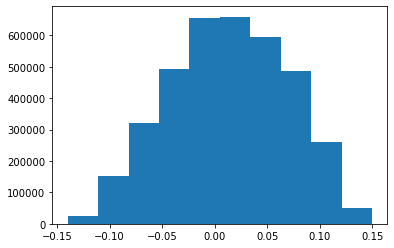

In [30]:
plt.hist(deltaz)
plt.plot()

In [33]:
# z = 0.7
    
sample = pd.concat(binned_g[50:70])
sample_real = binned[60].copy()
massive_sample = sample_real[sample_real.mass > 11].copy()
sample["comoving"] = cos.comoving_distance(sample["z_phot_median"])
massive_sample["comoving"] = cos.comoving_distance(massive_sample["z_phot_median"])
dz = 0.1
sample["mean_red_z_scaled"] = sample["z_phot_median"]*(2.3/(dz*cos.hubble_distance*cos.inv_efunc(sample["z_phot_median"])))
sample["mean_red_z_scaled2"] = sample["z_phot_median"]*2.3/dz
massive_sample["mean_red_z_scaled2"] = massive_sample["z_phot_median"]*2.3/dz
sample["mean_red_z_scaled3"] = sample["comoving"]/10
massive_sample["mean_red_z_scaled3"] = massive_sample["comoving"]/10
mass_tree = spatial.cKDTree(massive_sample[["x", "y", "z_phot_median"]], copy_data = True)
tree = spatial.cKDTree(sample[["x", "y", "z_phot_median"]], copy_data = True)

r = 5
neighbors = mass_tree.query_ball_tree(tree, r)
counts = np.array([])
for i in range(0, len(neighbors)):
    counts = np.append(counts, len(neighbors[i]))
        
sample.reset_index(inplace=True, drop = True)
massive_sample.reset_index(drop = True, inplace=True)
massive_sample["neighbor_numbers"] = pd.Series(neighbors)
massive_sample["neighbors"] = pd.Series(counts)

deltaz = np.array([])
for i in range(0, len(massive_sample)):
    deltas = np.ones(len(massive_sample.neighbor_numbers[i]))*massive_sample.z_phot_median[i] - sample.z_phot_median[massive_sample.neighbor_numbers[i]]
    deltaz = np.append(deltaz, deltas)

[]

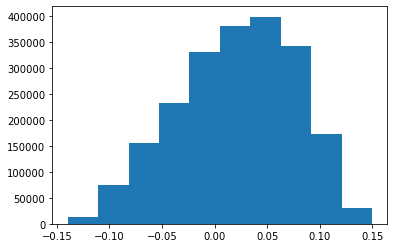

In [34]:
plt.hist(deltaz)
plt.plot()

In [35]:
# z = 0.9
    
sample = pd.concat(binned_g[70:90])
sample_real = binned[80].copy()
massive_sample = sample_real[sample_real.mass > 11].copy()
sample["comoving"] = cos.comoving_distance(sample["z_phot_median"])
massive_sample["comoving"] = cos.comoving_distance(massive_sample["z_phot_median"])
dz = 0.1
sample["mean_red_z_scaled"] = sample["z_phot_median"]*(2.3/(dz*cos.hubble_distance*cos.inv_efunc(sample["z_phot_median"])))
sample["mean_red_z_scaled2"] = sample["z_phot_median"]*2.3/dz
massive_sample["mean_red_z_scaled2"] = massive_sample["z_phot_median"]*2.3/dz
sample["mean_red_z_scaled3"] = sample["comoving"]/10
massive_sample["mean_red_z_scaled3"] = massive_sample["comoving"]/10
mass_tree = spatial.cKDTree(massive_sample[["x", "y", "z_phot_median"]], copy_data = True)
tree = spatial.cKDTree(sample[["x", "y", "z_phot_median"]], copy_data = True)

r = 5
neighbors = mass_tree.query_ball_tree(tree, r)
counts = np.array([])
for i in range(0, len(neighbors)):
    counts = np.append(counts, len(neighbors[i]))
        
sample.reset_index(inplace=True, drop = True)
massive_sample.reset_index(drop = True, inplace=True)
massive_sample["neighbor_numbers"] = pd.Series(neighbors)
massive_sample["neighbors"] = pd.Series(counts)

deltaz = np.array([])
for i in range(0, len(massive_sample)):
    deltas = np.ones(len(massive_sample.neighbor_numbers[i]))*massive_sample.z_phot_median[i] - sample.z_phot_median[massive_sample.neighbor_numbers[i]]
    deltaz = np.append(deltaz, deltas)

[]

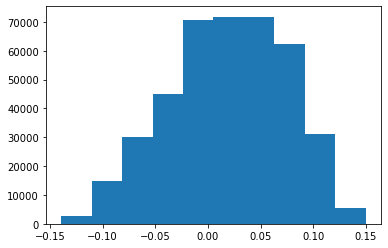

In [36]:
plt.hist(deltaz)
plt.plot()

## Z distribution: bins

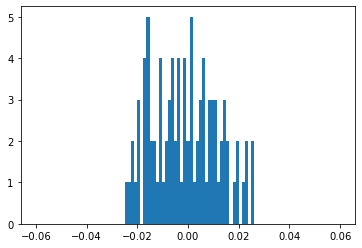

In [17]:
graph_subset = cluster_centrals[np.abs(cluster_centrals.mean_red - np.mean(cluster_centrals.mean_red)) < 0.005]
plt.hist(graph_subset.z_phot_median-graph_subset.mean_red, bins = np.linspace(-0.06, 0.06, 100))
plt.show()

## Z distribution: cluster member galaxies

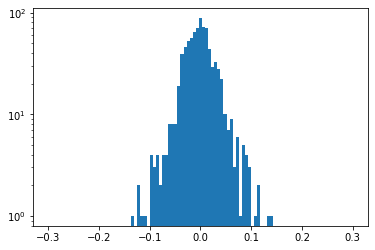

In [18]:
diff = cluster_centrals_3D.z_phot_median-cluster_centrals_3D.mean_z_cluster
plt.hist(diff[diff != 0], bins = np.linspace(-0.3, 0.3, 100), log = True)
plt.show()

## Radius distribution: initial binned aggregation

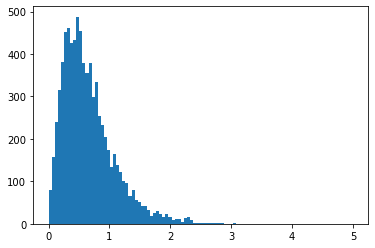

In [19]:
radius = np.sqrt((cluster_centrals.x - cluster_centrals.mean_x)**2 + (cluster_centrals.y - cluster_centrals.mean_y)**2)
radius = radius[radius>0]
radius = radius[radius>1e-2]
plt.hist(radius, bins = np.linspace(0, 5, 100))
plt.show()

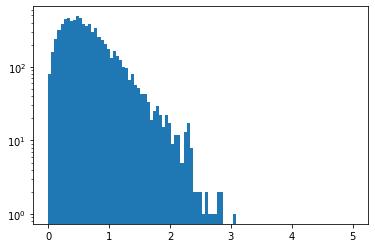

In [20]:
radius = np.sqrt((cluster_centrals.x - cluster_centrals.mean_x)**2 + (cluster_centrals.y - cluster_centrals.mean_y)**2)
radius = radius[radius>0]
radius = radius[radius>1e-2]
plt.hist(radius, bins = np.linspace(0, 5, 100), log=True)
plt.show()

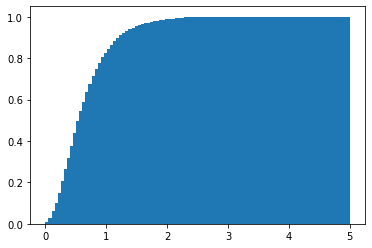

In [21]:
radius = np.sqrt((cluster_centrals.x - cluster_centrals.mean_x)**2 + (cluster_centrals.y - cluster_centrals.mean_y)**2)
radius = radius[radius>0]
radius = radius[radius>1e-2]
plt.hist(radius, bins = np.linspace(0, 5, 100), cumulative = True, density=True)
plt.show()

## Radius distribution: cluster member galaxies

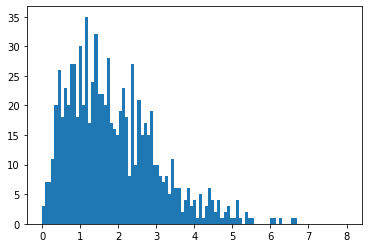

In [22]:
radius = np.sqrt((cluster_centrals_3D.x_individual - cluster_centrals_3D.mean_x_cluster)**2 + (cluster_centrals_3D.y_individual - cluster_centrals_3D.mean_y_cluster)**2)
radius = radius[radius>0]
radius = radius[radius>1e-10]
plt.hist(radius, bins = np.linspace(0, 8, 100))
plt.show()

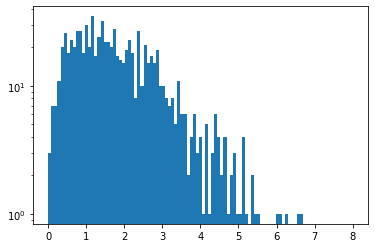

In [23]:
radius = np.sqrt((cluster_centrals_3D.x_individual - cluster_centrals_3D.mean_x_cluster)**2 + (cluster_centrals_3D.y_individual - cluster_centrals_3D.mean_y_cluster)**2)
radius = radius[radius>0]
radius = radius[radius>1e-10]
plt.hist(radius, bins = np.linspace(0, 8, 100), log = True)
plt.show()

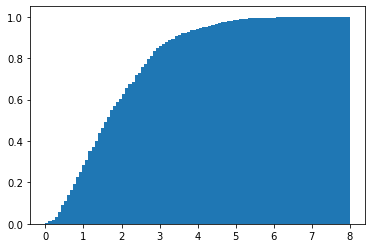

In [24]:
radius = np.sqrt((cluster_centrals_3D.x_individual - cluster_centrals_3D.mean_x_cluster)**2 + (cluster_centrals_3D.y_individual - cluster_centrals_3D.mean_y_cluster)**2)
radius = radius[radius>0]
radius = radius[radius>1e-10]
plt.hist(radius, bins = np.linspace(0, 8, 100), cumulative = True, density=True)
plt.show()

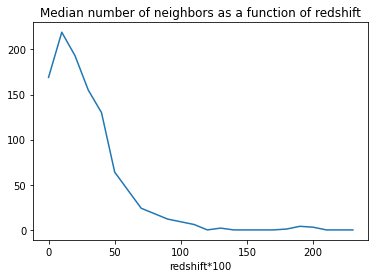

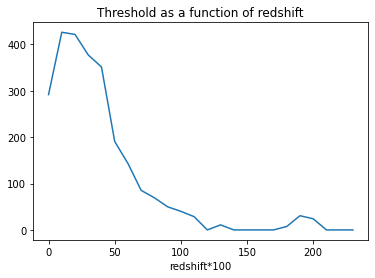

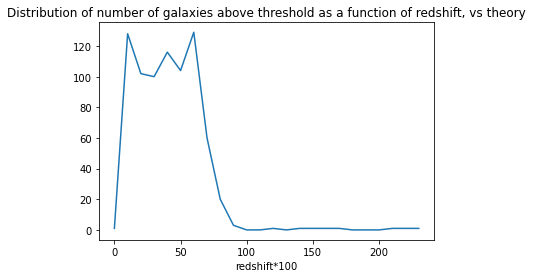

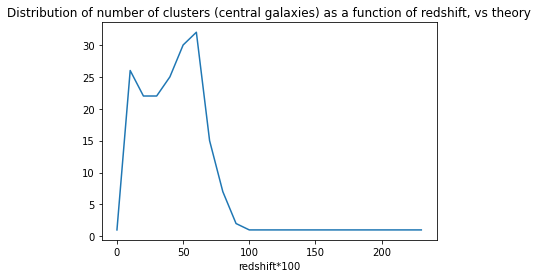

In [126]:
redshift = np.arange(0, len(binned), 10)
a = 1.5
b = 1.7
z0 = 0.3
r = (redshift/100)/z0
plt.plot(redshift, median_gal)
plt.title("Median number of neighbors as a function of redshift")
plt.xlabel("redshift*100")
plt.show()

plt.plot(redshift, thresh)
plt.title("Threshold as a function of redshift")
plt.xlabel("redshift*100")
plt.show()

plt.plot(redshift, dist_clusters)
#plt.plot(redshift, (25000)*(r**a)*(np.e**-r)**b)
plt.title("Distribution of number of galaxies above threshold as a function of redshift, vs theory")
plt.xlabel("redshift*100")
plt.show()
plt.plot(redshift, dist_most_massive)
#plt.plot(redshift, (12000)*(r**a)*(np.e**-r)**b)
plt.title("Distribution of number of clusters (central galaxies) as a function of redshift, vs theory")
plt.xlabel("redshift*100")
plt.show()

## Neighbors per radius

In [77]:
@dask.delayed
def cluster_residents_radius(binned, binned_g, C = 2.5, r = 2):
    sample_real = binned.copy()
    massive_sample = sample_real[sample_real.mass>11].copy()
    if len(massive_sample)>0:
        massive_tree = spatial.cKDTree(massive_sample[["x", "y"]])#, copy_data = True)
        sample = binned_g.copy()
        tree = spatial.cKDTree(sample[["x", "y"]])#, copy_data = True)
        
        neighbors = massive_tree.query_ball_tree(tree, np.copy(r))
        counts = np.array([])
        for i in range(0, len(neighbors)):
            counts = np.append(counts, len(neighbors[i]))
        
        sample.reset_index(inplace=True, drop = True)
        massive_sample.reset_index(inplace=True, drop = True)
        massive_sample["neighbor_numbers"] = pd.Series(neighbors)
        massive_sample["neighbors"] = pd.Series(counts)
        
        """threshold = C*np.median(counts) #Idea: scale C as 2.7/(1+z)**2 optionally with a boolean for scaling optionally
        clusters = massive_sample[massive_sample.neighbors>=threshold].copy()"""
        z = massive_sample.z_phot_median.mean()
        threshold = (C*(1 + z)*np.median(counts))/(1 + 0.5) #Idea: scale C as 2.7/(1+z)**2 optionally with a boolean for scaling optionally
        clusters = massive_sample[massive_sample.neighbors>=threshold].copy()
        
        if len(clusters)>0:
            cluster_tree = spatial.cKDTree(clusters[["x", "y"]])
            cluster_tree2 = spatial.cKDTree(clusters[["x", "y"]].copy())
            neighbors_c = cluster_tree.query_ball_tree(cluster_tree2, np.copy(r))
            counts_c = np.array([])
            for i in range(0, len(neighbors_c)):
                counts_c = np.append(counts_c, len(neighbors_c[i]))
        else:
            counts_c = np.array([])
            
    else:
        clusters = pd.DataFrame([[]])
        cluster_center = pd.DataFrame([[]])
        counts = np.array([])
        counts_c = np.array([])
    
    return np.array([np.mean(counts), np.mean(counts_c)]) # / sample.x.max() * sample.y.max() ?

In [78]:
rrange = np.arange(0.1, 5, 0.3)
radius_bins_sample = np.arange(0.1, 5, 0.3)
radius_bins_cluster = np.arange(0.1, 5, 0.3)
i = 0
for radius in rrange:
    delayed_results = []
    for b in range(len(binned)):
        delayed_result = cluster_residents_radius(dbinned[b], dbinned_g[b], r = radius)
        delayed_results.append(delayed_result)
    results = dask.compute(*delayed_results)
    aresults = np.array(results)
    radius_bins_sample[i] = np.nanmean(aresults[:, 0])
    radius_bins_cluster[i] = np.nanmean(aresults[:, 1])
    i += 1

KeyboardInterrupt: 

Future exception was never retrieved
future: <Future finished exception=KeyError('cluster_residents_radius-2b935906-2aa9-4267-b28a-be7d99789443')>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/distributed/client.py", line 1723, in _gather
    quiet_exceptions=AllExit,
  File "/opt/anaconda3/lib/python3.7/site-packages/distributed/utils.py", line 235, in All
    result = await tasks.next()
  File "/opt/anaconda3/lib/python3.7/site-packages/distributed/client.py", line 1712, in wait
    st = self.futures[k]
KeyError: 'cluster_residents_radius-522cff87-2d40-4e61-ab3b-c0141f8c41a8'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.throw(*exc_info)  # type: ignore
  File "/opt/anaconda3/lib/python3.7/site-packages/distributed/utils.py", line 248, in quiet
    yield task
  File "/opt/anaconda

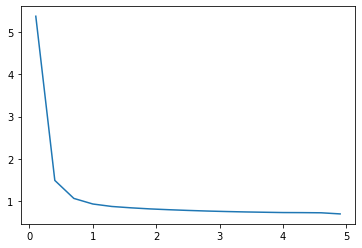

In [16]:
plt.plot(rrange, np.gradient(radius_bins_sample)/rrange, "-")
plt.show()

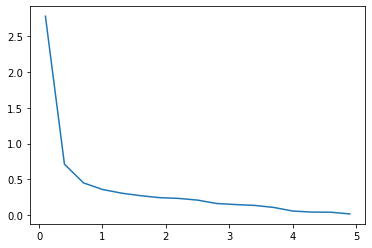

In [17]:
plt.plot(rrange, np.gradient(radius_bins_cluster)/rrange, "-")
plt.show()

## Mass calculation and true neighbors

In [58]:
sample = pd.DataFrame()
for i in range(len(binned_g)):
    sample = pd.concat([sample, binned_g[i]])
sample["comoving"] = cos.comoving_distance(sample["z_phot_median"])
dz = 0.1
sample["mean_red_z_scaled"] = sample["z_phot_median"]*(2.3/(dz*cos.hubble_distance*cos.inv_efunc(sample["z_phot_median"])))
sample["mean_red_z_scaled2"] = sample["z_phot_median"]*2.3/dz
cluster_centrals_3D["mean_red_z_scaled2"] = cluster_centrals_3D["z_phot_median"]*2.3/dz
sample["mean_red_z_scaled3"] = sample["comoving"]/10
cluster_centrals_3D["mean_red_z_scaled3"] = cluster_centrals_3D["comoving"]/10
mass_tree = spatial.cKDTree(cluster_centrals_3D[["x", "y", "z_phot_median"]], copy_data = True)
tree = spatial.cKDTree(sample[["x", "y", "z_phot_median"]], copy_data = True)

r = 2.3
neighbors = mass_tree.query_ball_tree(tree, r)
counts = np.array([])
for i in range(0, len(neighbors)):
    counts = np.append(counts, len(neighbors[i]))
        
sample.reset_index(inplace=True)
#cluster_centrals_3D.drop(columns = ['level_0', 'index'])
cluster_centrals_3D.reset_index(drop = True, inplace=True)
cluster_centrals_3D["neighbor_numbers"] = pd.Series(neighbors)
cluster_centrals_3D["neighbors"] = pd.Series(counts)

cluster_centrals_3D["neighbor_mass"] = np.zeros(len(cluster_centrals_3D))
masses = 10**sample.mass.to_numpy()/oversample
for i in range(0, len(cluster_centrals_3D)):
    cluster_centrals_3D["neighbor_mass"][i] = np.log10(np.sum(masses[cluster_centrals_3D.neighbor_numbers[i]]))

cluster_centrals_3D["deltaz"] = np.zeros(len(cluster_centrals_3D))
zs = sample.z_phot_median.to_numpy()
for i in range(0, len(cluster_centrals_3D)):
    zcenter = cluster_centrals_3D.z_phot_median[i] * np.ones(len(cluster_centrals_3D.neighbor_numbers[i]))
    cluster_centrals_3D["deltaz"][i] = np.mean(zcenter - zs[cluster_centrals_3D.neighbor_numbers[i]])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Mass calculation for massive galaxies only

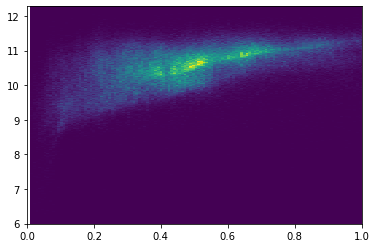

In [35]:
plt.hist2d(ra_dec.z_phot_median, ra_dec.mass, (300, 300), cmap="viridis")
plt.xlim(0, 1)
plt.title("Mass vs Redshift")
plt.show()

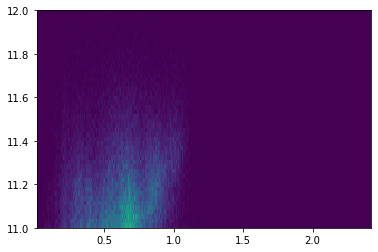

In [32]:
plt.hist2d(ra_dec.z_phot_median, ra_dec.mass, (300, 300), cmap="viridis")
plt.ylim(11, 12)
plt.show()

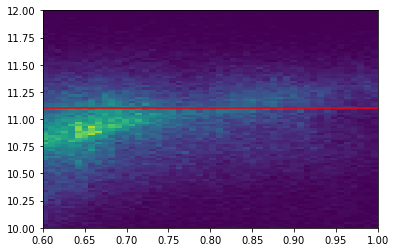

In [40]:
plt.hist2d(ra_dec.z_phot_median, ra_dec.mass, (300, 300), cmap="viridis")
plt.xlim(0.6, 1)
plt.ylim(10, 12)
plt.axhline(11.1, color = "red")
plt.title("Mass vs Redshift: Cutoff")
plt.show()

In [118]:
sample = binned_g.copy()
sample["mean_red_z_scaled2"] = sample["z_phot_median"]*2/dz
cluster_centrals_3D["mean_red_z_scaled2"] = cluster_centrals_3D["z_phot_median"]*2/dz
mass_tree = spatial.cKDTree(cluster_centrals_3D[["x", "y", "mean_red_z"]], copy_data = True)
sample_massive = sample[sample.mass > 11.1]
tree = spatial.cKDTree(sample_massive[["x", "y", "mean_red_z"]], copy_data = True)

r = 2.3
neighbors = mass_tree.query_ball_tree(tree, r)
counts = np.array([])
for i in range(0, len(neighbors)):
    counts = np.append(counts, len(neighbors[i]))
    
sample_massive.reset_index(inplace=True, drop = True)
#cluster_centrals_3D.drop(columns = ['level_0', 'index'])
cluster_centrals_3D.reset_index(drop = True, inplace=True)
cluster_centrals_3D["neighbor_numbers_massive"] = pd.Series(neighbors)
cluster_centrals_3D["neighbors_massive"] = pd.Series(counts)

cluster_centrals_3D["neighbor_mass_massive"] = np.zeros(len(cluster_centrals_3D))
masses = 10**sample_massive.mass/oversample
for i in range (0, len(cluster_centrals_3D)):
    cluster_centrals_3D.at[i, "neighbor_mass_massive"] = np.log10(np.sum(masses[cluster_centrals_3D.neighbor_numbers_massive[i]]))

TypeError: list indices must be integers or slices, not str

## Number of neighbors vs Z

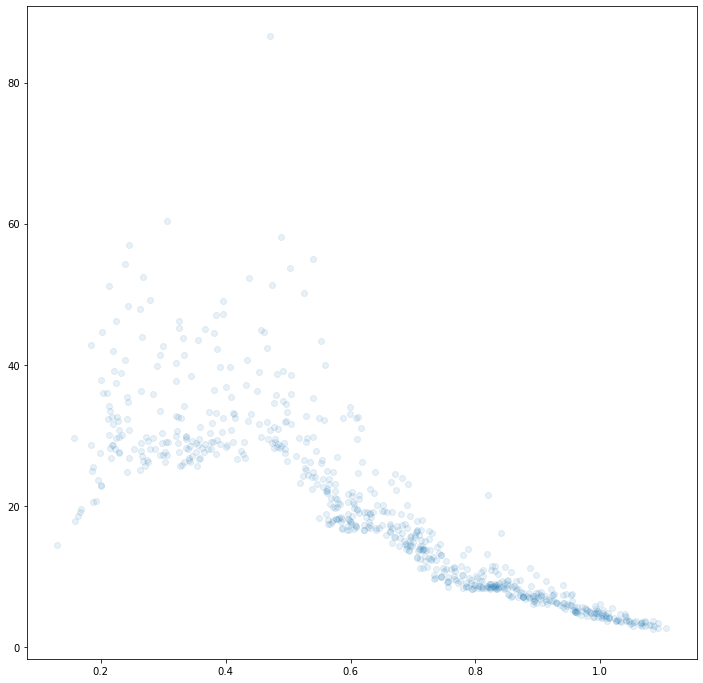

In [89]:
plt.figure(figsize = [12, 12])
plt.plot(cluster_centrals_3D.z_phot_median, cluster_centrals_3D.neighbors, 'o', alpha = 0.1)
plt.show()

## Mass of neighbors vs Z

### Regional neighbors, with central

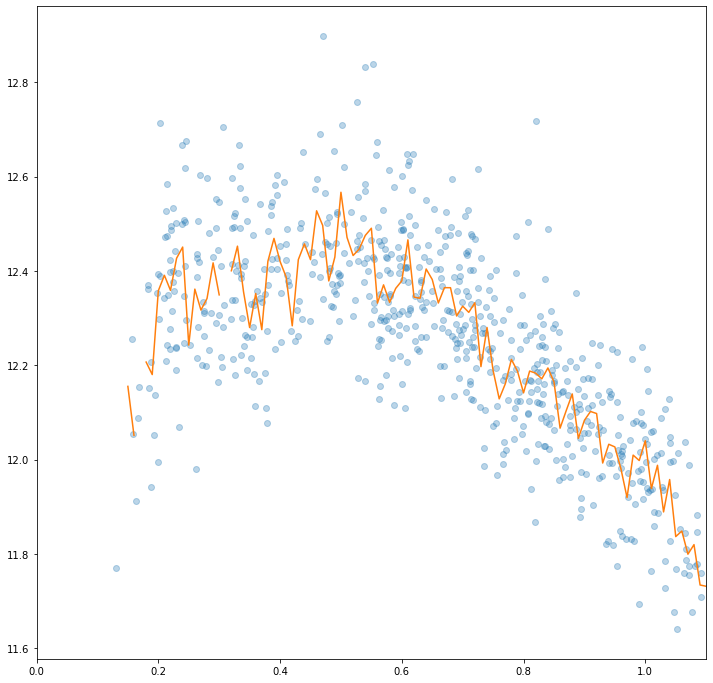

In [90]:
from scipy import stats
plt.figure(figsize = [12, 12])
average = stats.binned_statistic(cluster_centrals_3D[cluster_centrals_3D.neighbor_mass > -1e7].z_phot_median, cluster_centrals_3D[cluster_centrals_3D.neighbor_mass > -1e7].neighbor_mass, "mean", bins = np.linspace(0.1, ra_dec.z_phot_median.max(), len(bins)+1))
plt.plot(cluster_centrals_3D.z_phot_median, cluster_centrals_3D.neighbor_mass, 'o', alpha = 0.3)
a, b, c = np.polyfit(cluster_centrals_3D.z_phot_median, cluster_centrals_3D.neighbor_mass, 2)
r = cluster_centrals_3D.z_phot_median
plt.plot(bins, average[0])
#plt.plot(r, a*r**2 + b*r + c, ".r")
plt.xlim(0, 1.1)
plt.show()

### Regional neighbors, without central

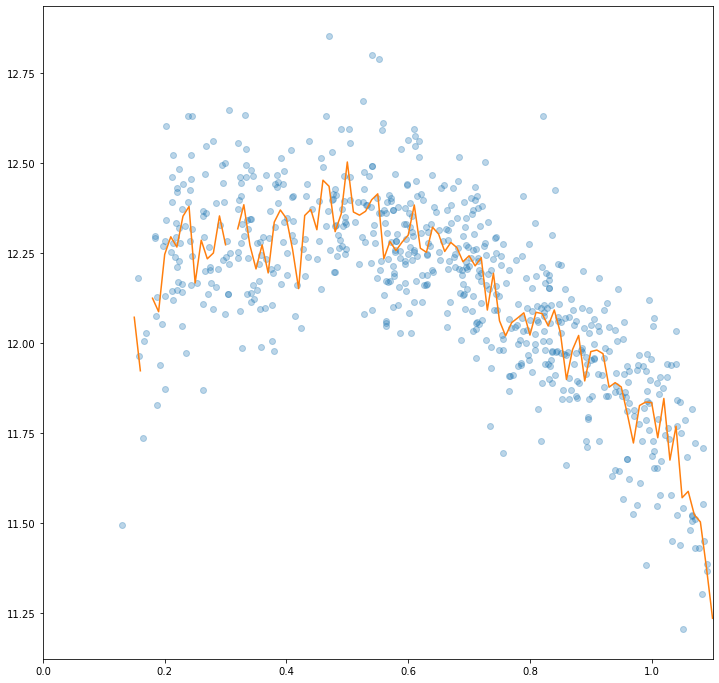

In [91]:
from scipy import stats
plt.figure(figsize = [12, 12])
average = stats.binned_statistic(cluster_centrals_3D[cluster_centrals_3D.neighbor_mass_wo > -1e7].z_phot_median, cluster_centrals_3D[cluster_centrals_3D.neighbor_mass_wo > -1e7].neighbor_mass_wo, "mean", bins = np.linspace(0.1, ra_dec.z_phot_median.max(), len(bins)+1))
plt.plot(cluster_centrals_3D.z_phot_median, cluster_centrals_3D.neighbor_mass_wo, 'o', alpha = 0.3)
a, b, c = np.polyfit(cluster_centrals_3D.z_phot_median, cluster_centrals_3D.neighbor_mass_wo, 2)
r = cluster_centrals_3D.z_phot_median
plt.plot(bins, average[0])
#plt.plot(r, a*r**2 + b*r + c, ".r")
plt.xlim(0, 1.1)
plt.show()

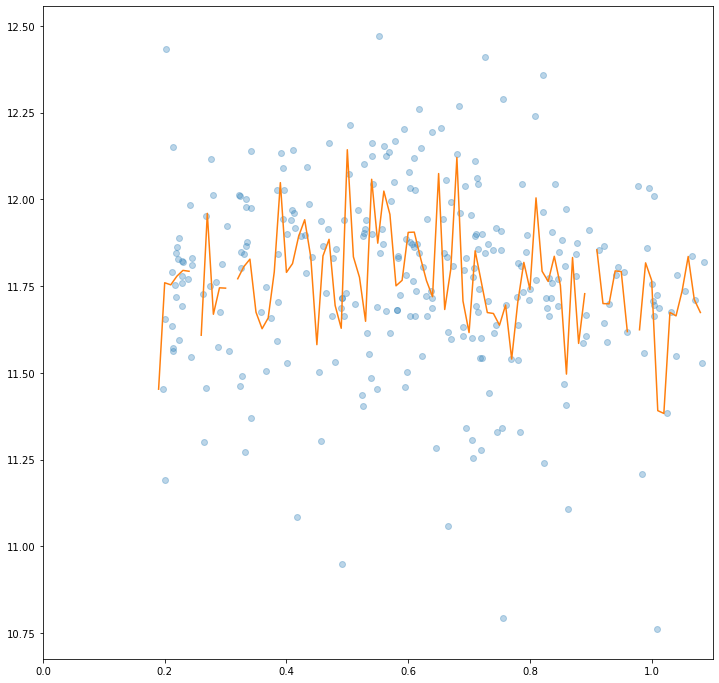

In [146]:
from scipy import stats
plt.figure(figsize = [12, 12])
average = stats.binned_statistic(cluster_centrals_3D[cluster_centrals_3D.neighbor_mass_massive > -1e7].z_phot_median, cluster_centrals_3D[cluster_centrals_3D.neighbor_mass_massive > -1e7].neighbor_mass_massive, "mean", bins = np.linspace(0.1, ra_dec.z_phot_median.max(), len(bins)+1))
plt.plot(cluster_centrals_3D.z_phot_median, cluster_centrals_3D.neighbor_mass_massive, 'o', alpha = 0.3)
a, b, c = np.polyfit(cluster_centrals_3D.z_phot_median, cluster_centrals_3D.neighbor_mass_massive, 2)
r = cluster_centrals_3D.z_phot_median
plt.plot(bins, average[0])
#plt.plot(r, a*r**2 + b*r + c, ".r")
plt.xlim(0, 1.1)
plt.show()

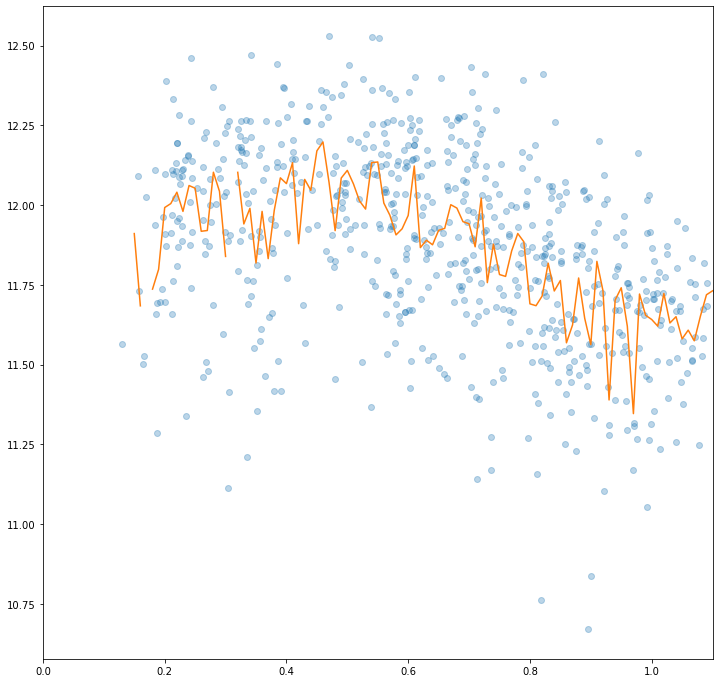

In [94]:
from scipy import stats
plt.figure(figsize = [12, 12])
average = stats.binned_statistic(cluster_centrals_3D[cluster_centrals_3D.local_neighbor_mass > -1e7].z_phot_median, cluster_centrals_3D[cluster_centrals_3D.local_neighbor_mass > -1e7].local_neighbor_mass, "mean", bins = np.linspace(0.1, ra_dec.z_phot_median.max(), len(bins)+1))
plt.plot(cluster_centrals_3D.z_phot_median, cluster_centrals_3D.local_neighbor_mass, 'o', alpha = 0.3)
a, b, c = np.polyfit(cluster_centrals_3D.z_phot_median, cluster_centrals_3D.local_neighbor_mass, 2)
r = cluster_centrals_3D.z_phot_median
plt.plot(bins, average[0])
#plt.plot(r, a*r**2 + b*r + c, ".r")
plt.xlim(0, 1.1)
plt.show()

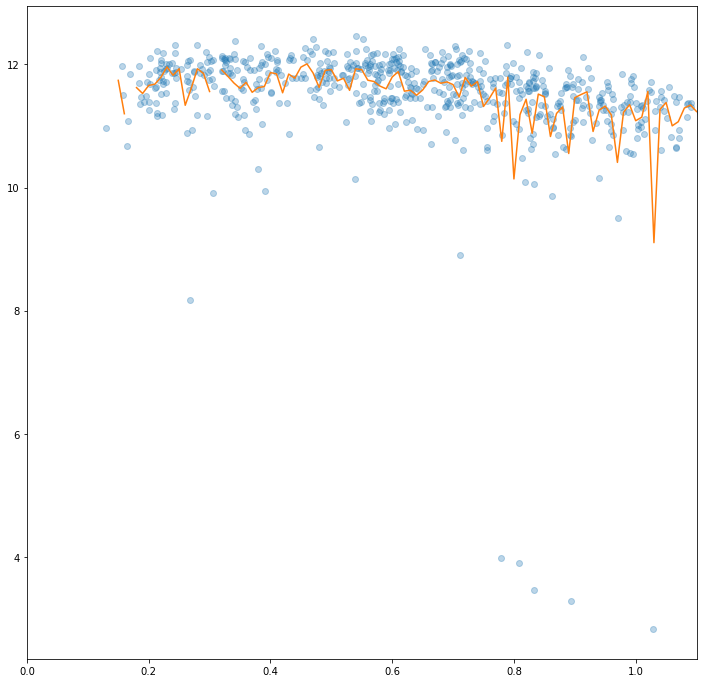

In [95]:
from scipy import stats
plt.figure(figsize = [12, 12])
average = stats.binned_statistic(cluster_centrals_3D[cluster_centrals_3D.local_neighbor_mass_wo > -1e7].z_phot_median, cluster_centrals_3D[cluster_centrals_3D.local_neighbor_mass_wo > -1e7].local_neighbor_mass_wo, "mean", bins = np.linspace(0.1, ra_dec.z_phot_median.max(), len(bins)+1))
plt.plot(cluster_centrals_3D.z_phot_median, cluster_centrals_3D.local_neighbor_mass_wo, 'o', alpha = 0.3)
a, b, c = np.polyfit(cluster_centrals_3D.z_phot_median, cluster_centrals_3D.local_neighbor_mass_wo, 2)
r = cluster_centrals_3D.z_phot_median
plt.plot(bins, average[0])
#plt.plot(r, a*r**2 + b*r + c, ".r")
plt.xlim(0, 1.1)
plt.show()